Reading NIfTI and DICOM files

In [7]:
import nibabel as nib
import pydicom
import matplotlib.pyplot as plt
import os
import numpy as np


In [8]:
img_nii = nib.load("/content/drive/MyDrive/sub-62038_ses-1_acq-t1csmp2ragesag06mmUNIDEN_T1w.nii")

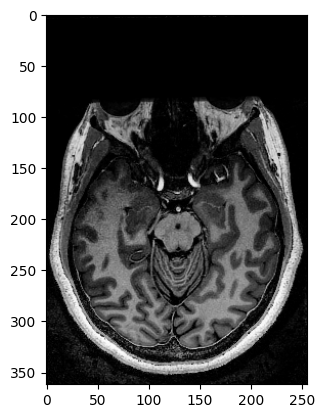

In [9]:
brain_dcm = pydicom.dcmread("/content/drive/MyDrive/brain/image.0177.dcm")
plt.imshow(brain_dcm.pixel_array, cmap="gray")
plt.show()

Internal Structure and metadata of NIfTI file

In [10]:
data = img_nii.get_fdata()
data.shape

(256, 362, 384)

In [11]:
affine = img_nii.affine
print("Affine matrix:\n", affine)


Affine matrix:
 [[ 6.29074156e-01 -1.33072212e-02 -3.11387163e-02 -7.36054077e+01]
 [ 1.63442213e-02  6.21981978e-01  5.91654330e-02 -1.00073349e+02]
 [ 2.99664345e-02 -5.98863661e-02  6.21413589e-01 -1.19990189e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [13]:
# Get voxel dimensions directly
voxel_sizes = img_nii.header.get_zooms()[:3]  # First 3 elements are spatial

print(f"Voxel spacing: {voxel_sizes}")


Voxel spacing: (np.float32(0.63), np.float32(0.625), np.float32(0.625))


In [14]:
header = img_nii.header
dtype = header.get_data_dtype()


bitpix = header['bitpix']  # bits per pixel
print(f"Datatype: {dtype}")
print(f"Bits per pixel: {bitpix}")


Datatype: int16
Bits per pixel: 16


In [42]:
# Access individual fields
print("=== Basic Header Fields ===")
print(f"sizeof_hdr: {header['sizeof_hdr']}")  # Header size (should be 348)
print(f"dim_info: {header['dim_info']}")      # MRI slice ordering
print(f"dim: {header['dim']}")                # Data array dimensions
print(f"intent_p1: {header['intent_p1']}")   # Intent parameters
print(f"intent_p2: {header['intent_p2']}")
print(f"intent_p3: {header['intent_p3']}")
print(f"intent_code: {header['intent_code']}")  # Intent of dataset
print(f"datatype: {header['datatype']}")     # Data type code
print(f"bitpix: {header['bitpix']}")          # Bits per pixel
print(f"slice_start: {header['slice_start']}")  # First slice index
print(f"slice_end: {header['slice_end']}")      # Last slice index
print(f"pixdim: {header['pixdim']}")            # Voxel dimensions

=== Basic Header Fields ===
sizeof_hdr: 348
dim_info: 54
dim: [  3 256 362 384   1   1   1   1]
intent_p1: 0.0
intent_p2: 0.0
intent_p3: 0.0
intent_code: 0
datatype: 4
bitpix: 16
slice_start: 0
slice_end: 0
pixdim: [1.    0.63  0.625 0.625 6.    0.    0.    0.   ]


DICOM File Metadata

In [16]:
brain_dcm.PatientName

'NIFTI'

In [17]:
brain_dcm.StudyDate

''

In [18]:
brain_dcm.Modality

'MR'

In [19]:
brain_dcm.PixelSpacing

[.625, .629999995231628]

In [20]:
brain_dcm.SliceThickness

'0.625'

In [21]:
brain_dcm.ImagePositionPatient

[-76.524298602597, -139.04302905709, -24.598929964964]

Stacking DICOM files into 3D volume

In [22]:
import os
from pathlib import Path
import pydicom

dir_path = r"/content/drive/MyDrive/brain"

dicom_set = []
for root, _, filenames in os.walk(dir_path):
    for filename in filenames:
        dcm_path = Path(root, filename)
        if dcm_path.suffix == ".dcm":
            try:
                dicom = pydicom.dcmread(dcm_path, force=True)
            except IOError as e:
                print(f"Can't import {dcm_path.stem}")
            else:
                dicom_set.append(dicom)

In [24]:
#Sorting by Instance Number

sorted_list = sorted(dicom_set, key=lambda x: x.InstanceNumber)

Creating 3D numpy array to represent the volume

In [25]:
volume = np.stack([s.pixel_array for s in sorted_list])

In [41]:
volume.shape

(384, 362, 256)

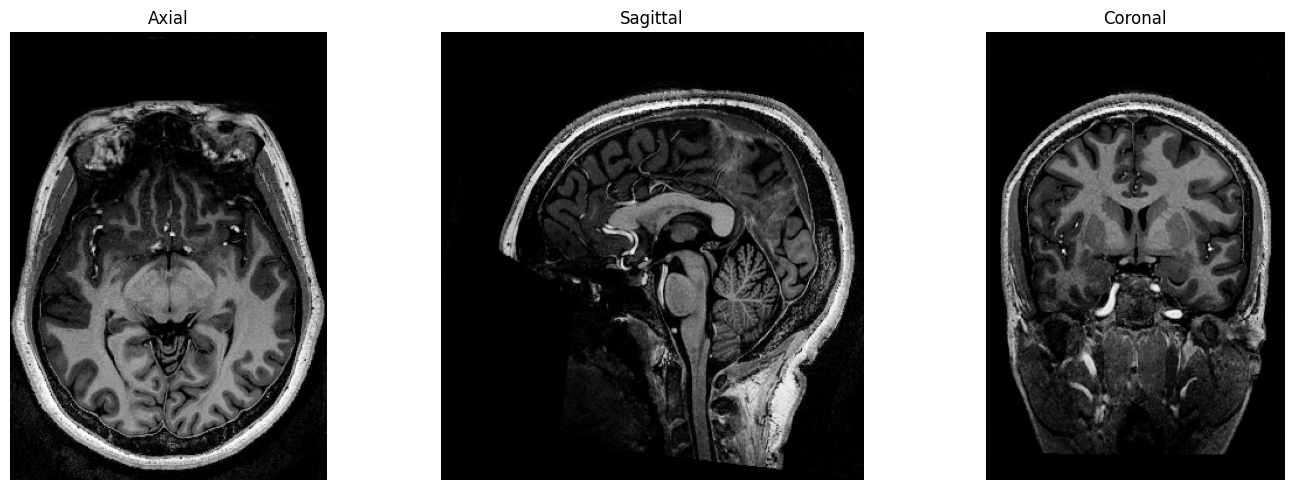

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Axial (original plane)
ax1.imshow(volume[volume.shape[0]//2, :, :], cmap='gray')
ax1.set_title('Axial')
ax1.axis('off')

# Sagittal (side view)
ax2.imshow(volume[:, :, volume.shape[2]//2], cmap='gray', origin='lower')
ax2.set_title('Sagittal')
ax2.axis('off')

# Coronal (front view)
ax3.imshow(volume[:, volume.shape[1]//2, :], cmap='gray', origin='lower')
ax3.set_title('Coronal')
ax3.axis('off')

plt.tight_layout()
plt.show()

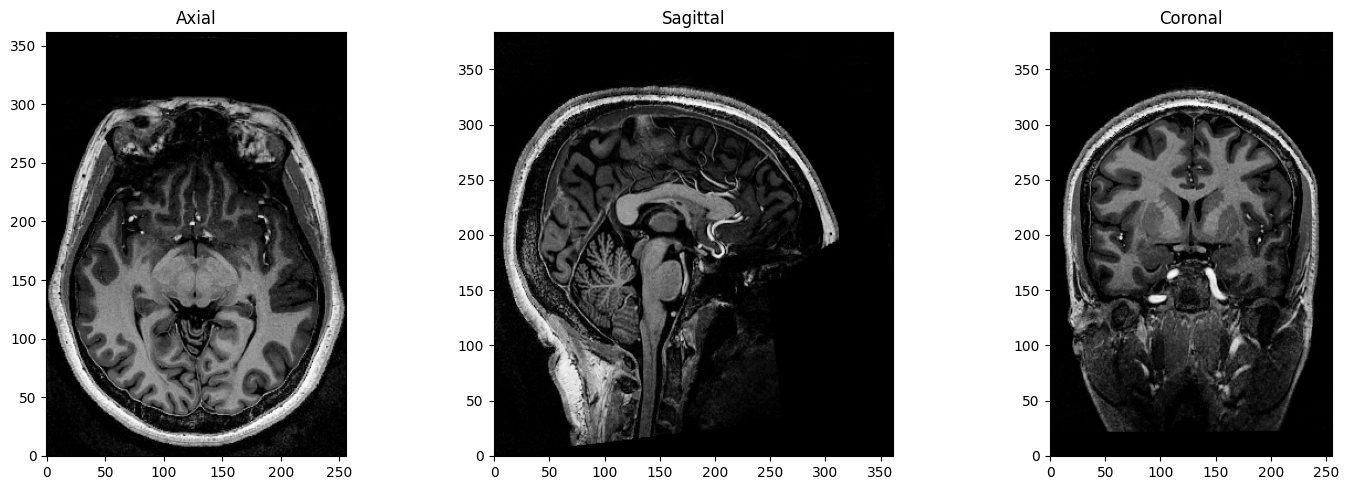

In [28]:
    nx, ny, nz = data.shape[:3]
    mid_x, mid_y, mid_z = nx//2, ny//2, nz//2


    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    ax1.imshow(data[:, :, mid_z].T, cmap='gray', origin='lower')
    ax1.set_title('Axial')

    ax2.imshow(data[mid_x, :, :].T, cmap='gray', origin='lower')
    ax2.set_title('Sagittal')

    ax3.imshow(data[:, mid_y, :].T, cmap='gray', origin='lower')
    ax3.set_title('Coronal')

    plt.tight_layout()
    plt.show()


The affine matrix(NIfTI) denotes many things.
$$
\begin{pmatrix}
m11 & m12& m13& m14 \\
 m21 &m22& m23 &m24 \\
 m31& m32 &m33 &m34\\
   0 &  0 &  0 &  1
\end{pmatrix}
$$

The first three diagonal elements often represent voxel spacing when there is no rotaion present
Off-diagonal elements represent obliques and rotation.
While the other elements denote the relation of voxel axis and real axis

In [27]:
img_nii.affine

array([[ 6.29074156e-01, -1.33072212e-02, -3.11387163e-02,
        -7.36054077e+01],
       [ 1.63442213e-02,  6.21981978e-01,  5.91654330e-02,
        -1.00073349e+02],
       [ 2.99664345e-02, -5.98863661e-02,  6.21413589e-01,
        -1.19990189e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

From the above affine matrix we can devise that

**First row (X-mapping): [0.629, -0.013, -0.031, -73.6]**

1. Strongly positive X component → voxel i-index increases toward anatomical RIGHT
2. Small negative Y,Z components indicate slight posterior and inferior tilt

**Second row (Y-mapping): [0.016, 0.622, 0.059, -100.1]**

1. Strongly positive Y component → voxel j-index increases toward ANTERIOR
2. Small positive Z component indicates slight superior tilt

**Third row (Z-mapping): [0.030, -0.060, 0.621, -120.0]**

1. Strongly positive Z component → voxel k-index increases toward SUPERIOR
2. Small negative Y component indicates slight posterior tilt

The small values of off-diagonal elements represent that the image planes are not exactly aligned with the anatomical axes.


**Translation**

The image center is offset by approximately:

1. 73.6 mm left of scanner center
2. 100.1 mm posterior to scanner center
3. 120.0 mm inferior to scanner center

#**Orientation handling in DICOM vs NIfTI**

##**DICOM**
* DICOM has a slice by slice approach towards data
* Each DICOM file contains its own orientation information
* Image Orientation Patient: [Xx, Xy, Xz, Yx, Yy, Yz] (denotes the Direction cosines of the first row and first column of pixels respectively)
* Image Position Patient: [x, y, z] (3D coordinates (in mm) of the center of the first pixel (top-left corner))
* Direct mapping to scanner/patient coordinate system

##**NIfTI**

* One affine matrix describes entire 3D volume and most of the charecteristics
* Assumes regular, rectangular voxel arrangement


#**Key differences between DICOM and NIfTI**


##**DICOM**
* Clinical workflows - designed for hospitals, radiology departments, and medical devices. Maintains complete patient context and regulatory compliance.
* Standardized tags covering patient info, acquisition parameters, equipment details.
* Multiple files: One per 2D slice (100-500 files per 3D scan)
* This reflects that the dicom files are fault tolerant(one faulty file does not destroy the whole data)
* Python Context : Complex multi-file handling, series reconstruction needed

##**NIfTI**

* Designed for analysis and visualization tools
* Optimized for neuroimaging studies, statistical analysis, and brain template alignment. Minimal metadata, maximum processing efficiency.
* Header with essential spatial/temporal parameters(less than DICOM)
* Complete 3D/4D volume in one .nii/.nii.gz file
* One-line loading, excellent tool ecosystem